In [157]:
import numpy as np
import pandas as pd
dp_ori_df = pd.read_csv('synthetic data/doppelGANger/dp_ori.csv')
dp_gen_df = pd.read_csv('synthetic data/doppelGANger/dp_gen.csv')
tgan_ori_df = pd.read_csv('synthetic data/TGAN/tgan_ori.csv')
tgan_gen_df = pd.read_csv('synthetic data/TGAN/tgan_gen.csv')

Remove all-zero rows

In [158]:
dp_ori_nozero = dp_ori_df[np.any(abs(dp_ori_df)!=0,axis=1)].copy()
dp_gen_nozero = dp_gen_df[np.any(abs(dp_gen_df)!=0,axis=1)].copy()


In [159]:
tgan_ori_nozero = tgan_ori_df[np.any(abs(tgan_ori_df)!=0,axis=1)].copy()
tgan_gen_nozero = tgan_gen_df[np.any(abs(tgan_gen_df)!=0,axis=1)].copy()

For numerical variables, in order to compare the distribution within each column, we firstly plot and compare the pdf (probability density function) and cdf (cumulative density function); to compare how the two distributions are similar numerically, we apply Kolmogorov-Smirnov test. It is a hypothesis test, the null test is the two samples are drawn from the same distribution, the alternative test is the cdf's are "two sided" different.

In [160]:
def KSTest(ori_nozero,gen_nozero,size = 100):
    keys = (ori_nozero.keys()).tolist()
    n = len(keys)
    l = min(len(ori_nozero),len(gen_nozero))

    import matplotlib.pyplot as plt
    from scipy import stats
    for num in range(n):
        name = keys[num]
        ser_ori = ori_nozero[name].values[:l]
        ser_gen = gen_nozero[name].values[:l]
        df= pd.DataFrame({'ori':ser_ori, 'gen':ser_gen})
        df.plot.hist(bins=100,alpha=0.5,cumulative=False)
        plt.title(name+'_pdf')
        df.plot.hist(bins=100,alpha=0.5,cumulative=True,histtype='step')
        plt.title(name+'_cdf')
        plt.show()

        value = [0,0]
        for k in range(10):
        #Randomly take 100 samples from the generated and real data, since the total sample size is 40,000+, which is too
        #large and the null hypothesis can get easily rejected.
            idx = np.random.permutation(l)
            idx = idx[:size]
            name = keys[num]
            ser_ori = ori_nozero[name].values[idx]
            ser_gen = gen_nozero[name].values[idx]
            (t,p) = stats.ks_2samp(ser_ori, ser_gen)
            value[0] = value[0]+t
            value[1] = value[1]+p
        display(np.array(value)/10) #the displayed array is the average (statistic, p_value), the closer to 0 the p is
        #the null hypothesis is more likely to be rejected.



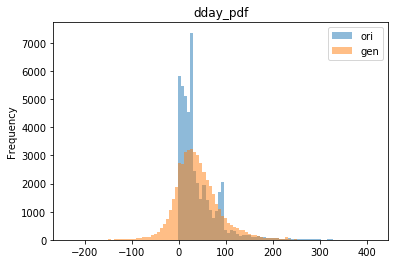

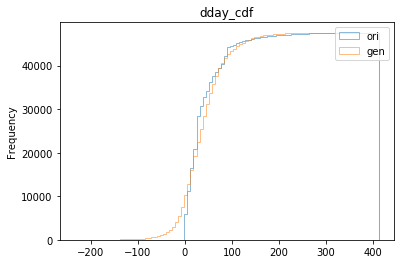

array([0.189     , 0.08666675])

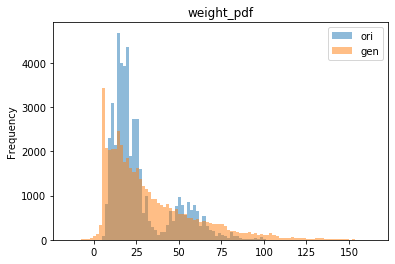

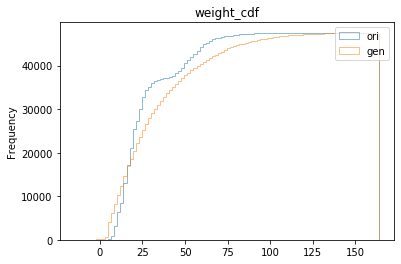

array([0.211     , 0.11292438])

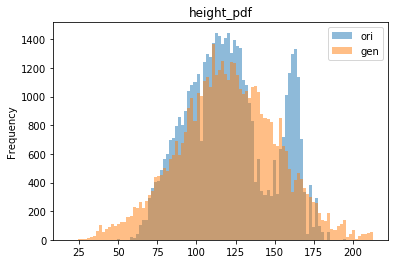

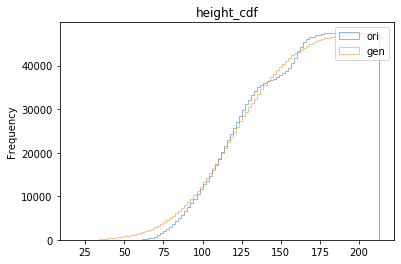

array([0.139     , 0.36109885])

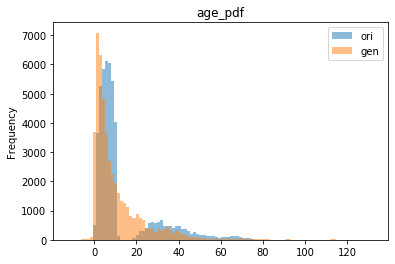

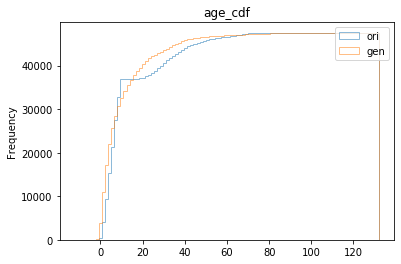

array([0.192     , 0.13245128])

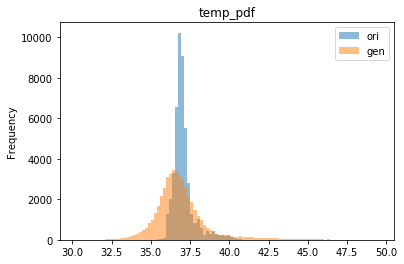

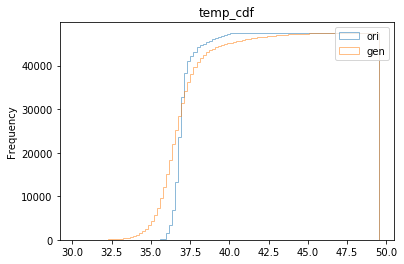

array([0.329     , 0.00069424])

In [161]:
KSTest(dp_ori_nozero,dp_gen_nozero)

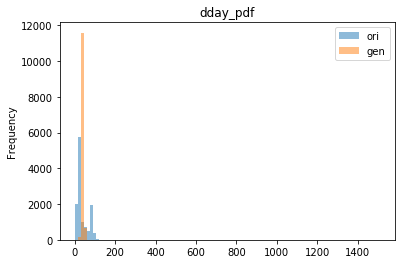

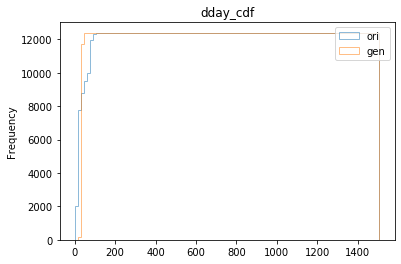

array([6.32200000e-01, 1.94697839e-87])

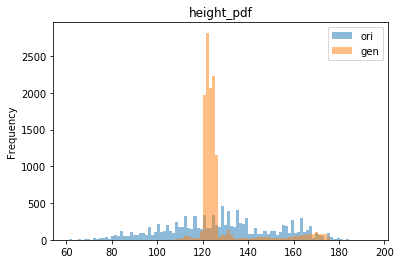

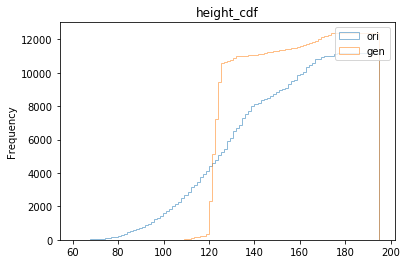

array([4.50800000e-01, 1.72058867e-37])

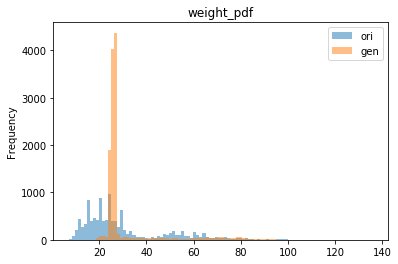

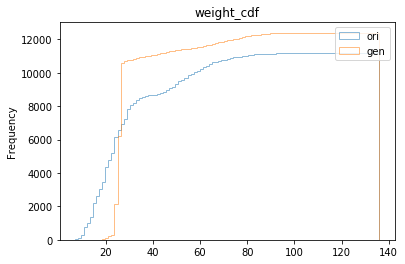

array([4.24800000e-01, 8.15699057e-38])

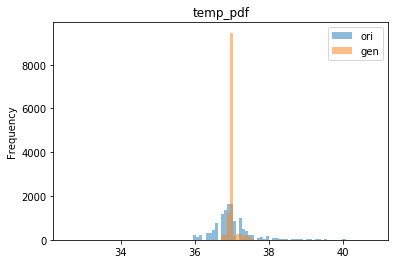

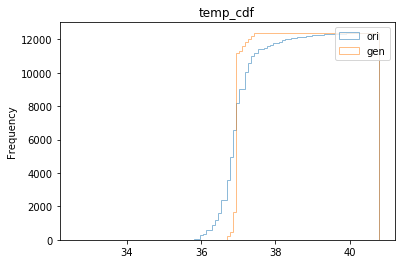

array([4.81000000e-01, 2.65148153e-45])

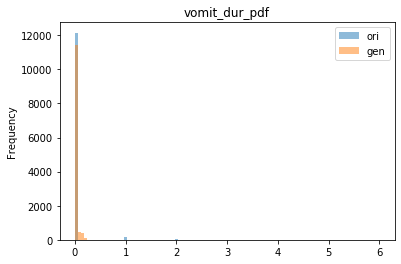

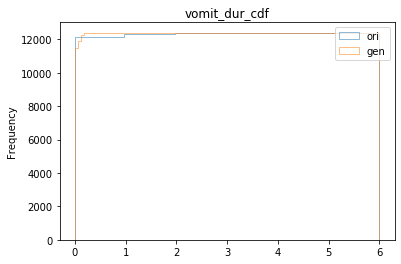

array([9.78200000e-001, 3.13548996e-266])

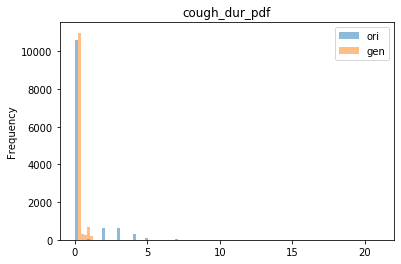

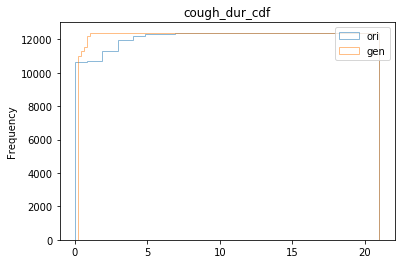

array([8.57600000e-001, 5.66402079e-178])

In [162]:
#Only do KS test for numerical variables
KSTest(tgan_ori_nozero.iloc[:,:6],tgan_gen_nozero.iloc[:,:6],size=500)

We can conclude that for each column, the original and generated data don't look like being drawn from the same dsitribution, but the doppelGANger synthetic data gains better result than TGANs synthetic data.

For categorical variables (only TGANs data contains categorical variables now), we hope to plot a scatter graph of the proportion of each category in each column in the synthetic data against that in the real data. An ideal synthetic data should lie on the diagonal y=x.

In [163]:
#.._cat means the part of the df only containing categorical variables, we'll process categorical variables plot (Lora's scatterplot) for this.
tgan_ori_cat = tgan_ori_nozero.iloc[:,6:]
tgan_gen_cat = tgan_gen_nozero.iloc[:,6:]

gen       ori
diar_No  0.0  0.000000  0.022357
         1.0  1.000000  0.977643
diar_Yes 0.0  1.000000  0.977643
         1.0  0.000000  0.022357
head_No  1.0  0.906457  0.889346
         0.0  0.093543  0.110654
head_Yes 0.0  0.906457  0.889346
         1.0  0.093543  0.110654

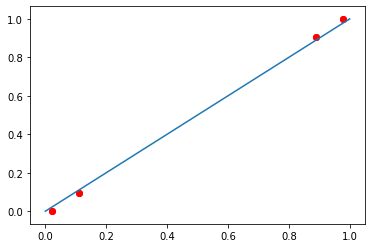

In [166]:
#since the categorical variables are OHE, so we regard entries > 0.5 as 1, entries < 0.5 as 0 for tgan_gen_cat
tgan_gen_cat = tgan_gen_cat[tgan_gen_cat<0.5].fillna(1)
tgan_gen_cat = tgan_gen_cat[tgan_gen_cat>0.5].fillna(0)
def CatProportion(series):
    return series.value_counts()/len(series)

cat_keys = (tgan_gen_cat.keys()).tolist()
first = True
name_index = []
cat_index = []
for name in cat_keys:
    df_1=pd.DataFrame({'gen':CatProportion(tgan_gen_cat[name]),'ori': CatProportion(tgan_ori_cat[name])})
    if first:
        v = df_1.values
        first = False
    else:
        v = np.concatenate((v,df_1.values),axis = 0)
    df1_index = df_1.index.tolist()
    name_index += [name]*len(df1_index)
    cat_index += df1_index

df_cat = pd.DataFrame(v, index = [name_index,cat_index], columns = ['gen','ori'])
df_cat = df_cat.fillna(0)
display(df_cat)
plt.scatter(df_cat['ori'],df_cat['gen'],c = 'r')
plt.plot([0,1])
plt.show()


The result looks nice.